## Imports

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sqlalchemy import create_engine, text
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE

## Loading data

In [215]:
# Подключаемся к базе данных

engine = create_engine('sqlite:///data/shop_database.db')
conn = engine.connect()

In [216]:
# Загружаем таблицы 

df_pers = pd.read_sql(sql=text('SELECT * FROM personal_data'),con=conn)

In [217]:
df_pers.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [218]:
df_pers.shape

(89241, 6)

In [219]:
df_coef = pd.read_sql(sql=text('SELECT * FROM personal_data_coeffs'),con=conn)

In [220]:
df_coef.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [221]:
df_coef.shape

(104989, 5)

In [222]:
df_purch = pd.read_sql(sql=text('SELECT * FROM purchases'),con=conn)

In [223]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [224]:
df_purch.shape

(786260, 7)

In [225]:
# Загружаем утерянные данные

df_lost = pd.read_csv('data\personal_data.csv.gz', compression='gzip', header=0)

In [226]:
df_lost.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [227]:
df_lost.shape

(15748, 5)

In [228]:
# Объединяем данные о клиентах с утерянными данными

df_clients = pd.concat([df_pers, df_lost])

In [229]:
df_clients.shape

(104989, 6)

In [230]:
# Добавляем признак с коэффициентом клиента

df_clients = df_clients.merge(df_coef[['id', 'personal_coef']], on='id', how='inner')

In [231]:
df_clients.head()

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,среднее,1201,32,0.5072
1,4,0.0,35,среднее,1134,32,0.5072
2,6,1.0,52,среднее,1188,32,0.4304
3,7,0.0,37,среднее,1198,32,0.5072
4,9,0.0,48,среднее,1134,32,0.5072


## Data Preparation

### Working with personal data

In [232]:
df_clients.describe()

,id,gender,age,city,country,personal_coef
count,104989.000000,89241.000000,104989.000000,104989.000000,104989.000000,104989.000000
mean,89084.680967,0.572965,38.016707,1133.788492,31.989075,0.458363
std,51414.198487,0.494650,12.283166,179.309965,0.943848,0.062570
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.233600
25%,44532.000000,0.000000,30.000000,1134.000000,32.000000,0.430400
50%,89158.000000,1.000000,38.000000,1167.000000,32.000000,0.468800
75%,133588.000000,1.000000,46.000000,1188.000000,32.000000,0.507200
max,178004.000000,1.000000,77.000000,1213.000000,51.000000,0.558400


In [233]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         89241 non-null   float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 6.4+ MB


[Text(0.5, 0, 'Возраст'), Text(0, 0.5, 'Кол-во')]

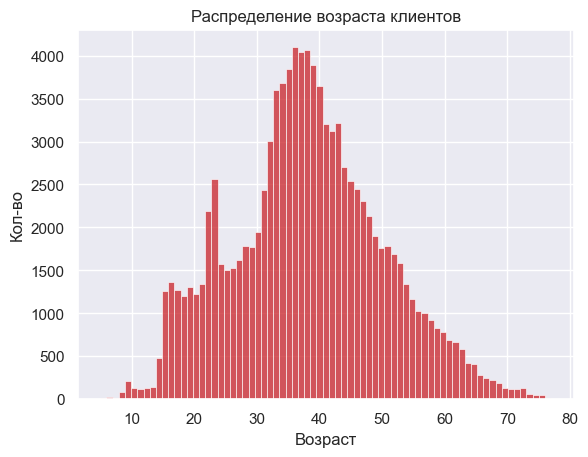

In [234]:
# Визуализируем некоторые распределения

fig,ax = plt.subplots()
sns.histplot(df_clients['age'], bins=73, color='#C92228')
ax.set_title('Распределение возраста клиентов')
ax.set(xlabel='Возраст', ylabel='Кол-во')

[[Text(0, 0, 'женщины'), Text(1, 0, 'мужчины')]]

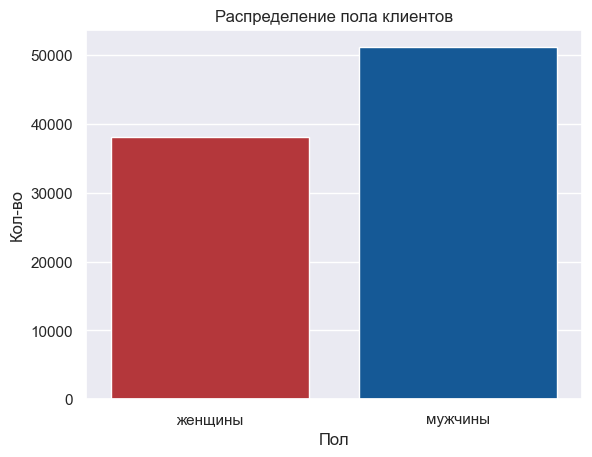

In [235]:
fig,ax = plt.subplots()
sns.countplot(x = df_clients['gender'],palette=['#C92228',"#005AAB"])
ax.set_title('Распределение пола клиентов')
ax.set(xlabel='Пол', ylabel='Кол-во')
ax.set(xticklabels=['женщины', 'мужчины'])


[Text(0.5, 0, 'Образование'), Text(0, 0.5, 'Кол-во')]

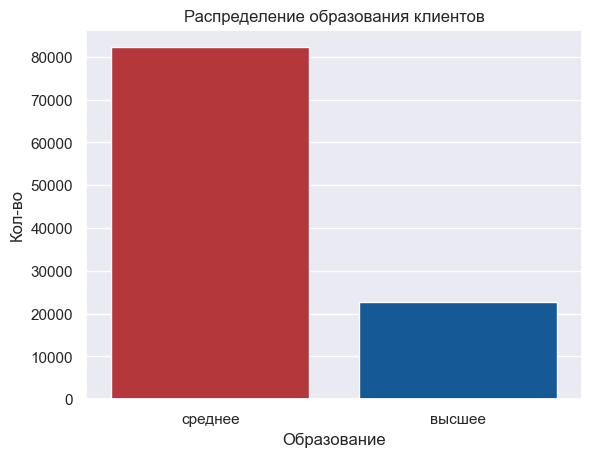

In [236]:
fig,ax = plt.subplots()
sns.countplot(x = df_clients['education'],palette=['#C92228',"#005AAB"])
ax.set_title('Распределение образования клиентов')
ax.set(xlabel='Образование', ylabel='Кол-во')

In [237]:
df_clients.duplicated().sum()

0

In [238]:
# Проверяем пропущенные значения

((df_clients.isna().sum() / len(df_clients)) * 100).sort_values(ascending=False)

gender           14.999667
id                0.000000
age               0.000000
education         0.000000
city              0.000000
country           0.000000
personal_coef     0.000000
dtype: float64

In [239]:
for column in df_clients.columns:
    print(column)
    print(df_clients[column].unique(), '\n')

id
[     0      4      6 ... 167019 116355  15885] 

gender
[ 0.  1. nan] 

age
[36 35 52 37 48 39 44 40 49 53 33 19 20 17 50 55 21 34 38 29 62 41 31 43
 16 32 18 30 23 25 42 24 63 45 56 58 22 47 27 51 28 26 54 57 11 46 65 13
 66 64 60 71  5 14 59 61 15 73  9  8 69 68 72 70  7 67 12 10 75  6 74 76
 77] 

education
['среднее' 'высшее'] 

city
[1201 1134 1188 1198 1190 1155  574 1178 1157 1203 1137 1204 1187 1181
 1172 1162 1185 1177 1168 1207 1166 1191 1202 1179  913 1154  338   74
 1205 1167 1159 1141 1142 1180 1150 1160 1199  609 1186 1151    3 1165
 1196 1194 1175 1161 1195 1173   33 1192 1152   48  501 1183 1156 1163
 1197 1200  218 1212    9 1176    1   73    0 1182   12 1153 1189   66
 1164   10 1170 1148 1211 1147 1158  875 1206 1171 1033 1169 1208 1174
    2   34 1133 1184   70   45  204 1135 1145 1092 1098 1093 1017  104
   62  580 1139   11  917  226 1144 1193  804  292   61   59  726   76
  307  536    7  123  515  261  588  174  269 1140  129   84  541  615
  990 1143  550  

In [240]:
# Преобразуем категориальный признак с помощью Label Encoder

le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])

In [241]:
# Разделяем выборку на обучающую и тестовую, для последущего заполнения признака о поле клиента.

df_train = df_clients[~df_clients['gender'].isna()].dropna()
print('df_train shape:',df_train.shape)

df_test = df_clients[df_clients['gender'].isna()]
print('df_test shape:',df_test.shape)

df_train shape: (89241, 7)
df_test shape: (15748, 7)


In [242]:
# В тестовой выборке признак пол не заполнен

x_train = df_train.drop(columns=['gender','id'])
y_train = df_train['gender']

x_test = df_test.drop(columns=['gender','id'])
y_test = df_test['gender']

In [243]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [39]:
# Осуществляем подбор гиперпараметров модели

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}

rs = RandomizedSearchCV(rfc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 14}
Best score:  0.9999022333801678


In [41]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}

rs = RandomizedSearchCV(gbc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 34, 'loss': 'log_loss', 'learning_rate': 1, 'criterion': 'squared_error'}
Best score:  0.9999511141094457


In [244]:
# Обучаем модель с лучшей оценкой f1 и предсказываем пол клиента на тестовой выборке

model = GradientBoostingClassifier(subsample=0.8, n_estimators=300, min_samples_split=16, min_samples_leaf=8, 
                                   max_features='sqrt', max_depth=2, loss= 'exponential', learning_rate=1,
                                   criterion='friedman_mse').fit(x_train, y_train)
df_test['gender'] = model.predict(x_test)

C:\Users\mayor\AppData\Local\Temp\ipykernel_11304\2634542672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender'] = model.predict(x_test)


In [245]:
df_test.head()

,id,gender,age,education,city,country,personal_coef
89241,101492,1.0,32,1,1188,32,0.4304
89242,42690,1.0,20,0,1134,32,0.4688
89243,113001,1.0,27,1,1187,32,0.4304
89244,163654,0.0,49,0,1160,32,0.5584
89245,69523,0.0,44,1,1137,32,0.5072


In [246]:
# Объединяем датафреймы

df_clients = pd.concat([df_train, df_test])

### Working with purchases

In [247]:
df_purch.describe()

,id,cost,product_sex,base_sale,dt
count,786260.000000,786260.000000,471548.000000,786260.000000,786260.000000
mean,89064.105357,5406.566271,0.575621,0.356883,25.129113
std,51386.509635,10394.947580,0.494249,0.479080,17.296781
min,0.000000,-30.000000,0.000000,0.000000,0.000000
25%,44435.500000,1499.000000,0.000000,0.000000,10.000000
50%,89387.500000,2999.000000,1.000000,0.000000,22.000000
75%,133427.000000,5599.000000,1.000000,1.000000,40.000000
max,178004.000000,446420.000000,1.000000,1.000000,58.000000


In [248]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [249]:
def get_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [250]:
get_outliers(df_purch['cost'])

(-4651.0, 11749.0)

[Text(0.5, 0, 'Стоимость'), Text(0, 0.5, 'Кол-во')]

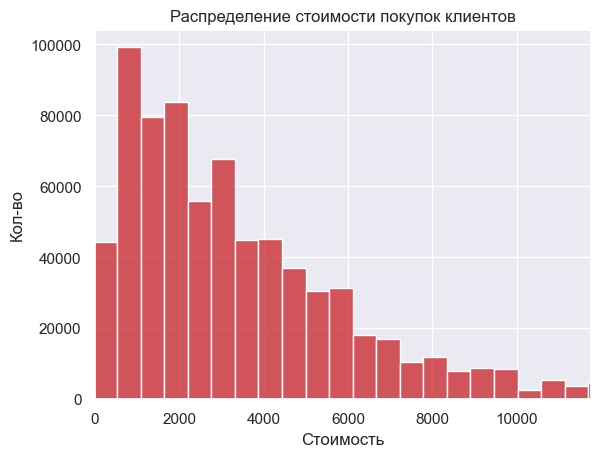

In [251]:
fig,ax = plt.subplots()
ax.set_xlim(0,11749.0)
sns.histplot(df_purch['cost'], bins=800, color='#C92228')
ax.set_title('Распределение стоимости покупок клиентов')
ax.set(xlabel='Стоимость', ylabel='Кол-во')

[[Text(0, 0, 'женcкий'), Text(1, 0, 'мужской')]]

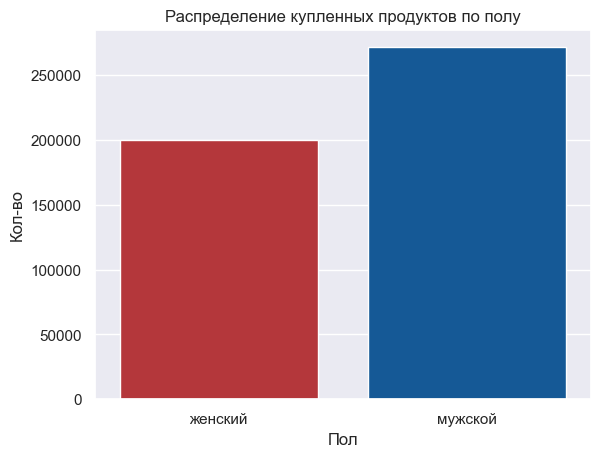

In [252]:
fig,ax = plt.subplots()
sns.countplot(x = df_purch['product_sex'],palette=['#C92228',"#005AAB"])
ax.set_title('Распределение купленных продуктов по полу')
ax.set(xlabel='Пол', ylabel='Кол-во')
ax.set(xticklabels=['женcкий', 'мужской'])

In [253]:
df_purch.duplicated().sum()

0

In [254]:
((df_purch.isna().sum() / len(df_purch)) * 100).sort_values(ascending=False)

product_sex    40.026454
colour         15.201587
id              0.000000
product         0.000000
cost            0.000000
base_sale       0.000000
dt              0.000000
dtype: float64

In [255]:
# Проверяем уникальные значения признаков в датафрейме

for column in df_purch.columns:
    print(column)
    print(df_purch[column].unique(), '\n')

id
[     0      3      4 ... 178001 178002 178004] 

product
['Велосипед горный женский Stern Mira 2.0 26"' 'Стол Outventure'
 'Набор Outventure: стол + 4 стула' ...
 'Клюшка детская Bauer Vapor 3X, Flex 55, P92'
 'Футболка мужская Reebok United By Fitness'
 'Бутсы мужские adidas Predator 19.3 TF'] 

colour
['белый/синий' 'зелёный' 'бежевый' ... 'бордовый/прозрачный/голубой'
 'синий/голубой/золотой/желтый' 'черный/циан'] 

cost
[ 13599   1499   4799 ...   5700  49899 174999] 

product_sex
[ 0. nan  1.] 

base_sale
[1 0] 

dt
[ 7 37 13 27 34  0  1  2 32  3  8 11 17 18 29 30  6 14 33 35 36 42 49 25
 39 55 56  4 26 28 45 51  5 15 50 52 12 16 19 21 22 23 31  9 58 41 44 57
 47 10 54 43 38 46 53 24 40 20 48] 



In [256]:
# Проверяем товары где не заполнен признак product_sex

df_purch['product'][df_purch['product_sex'].isnull()].value_counts()

Сабо Crocs Crocband                              2213
Рюкзак Demix                                     1914
Сумка FILA                                       1714
Кресло кемпинговое Outventure                    1705
Солнцезащитные очки Kappa                        1616
                                                 ... 
Панама Vans Level Up                                1
Рюкзак Dakine HELI PACK, 12 л                       1
Велосипед детский унисекс FORMAT Kids BMX 16"       1
Горные лыжи BLIZZARD Black Pearl 88 (Flat)          1
Клюшка детская Bauer Vapor 3X, Flex 55, P92         1
Name: product, Length: 13471, dtype: int64

In [257]:
# Заполняем признак product_sex исходя из описания товаров

df_purch['product_sex'] = df_purch['product_sex'].fillna(2)

In [258]:
# Заполняем пропущенное значение признака цвет товара значением 'другой'

df_purch['colour'] = df_purch['colour'].fillna('другой')

In [259]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,2.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27


In [260]:
# Проверяем частоту значений в признаках

for column in df_purch.columns:
    print(column)
    print(df_purch[column].value_counts(), '\n')

id
20770     569
16910     522
20570     420
35091     330
131874    326
         ... 
165413      1
12748       1
165409      1
56134       1
89967       1
Name: id, Length: 104989, dtype: int64 

product
Брюки мужские Demix                                                                                                                    4961
Шорты мужские Demix                                                                                                                    4650
Футболка мужская Demix                                                                                                                 3644
Лиф женский Joss                                                                                                                       3378
Футболка женская Demix                                                                                                                 3252
                                                                                              

In [261]:
# Объединяем дублирующиеся значения цвета

df_purch['colour'] = df_purch['colour'].replace(['чёрный'], 'черный')

In [275]:

df_purch['product_name'] = df_purch['product'].apply(lambda x: " ".join(re.findall('[А-Яа-я]+', x)))

In [276]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt,product_name
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,Велосипед горный женский
1,0,Стол Outventure,зелёный,1499,2.0,0,37,Стол
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,Набор стол стула
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,Бутсы мужские
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27,Мяч футбольный


## A/B test evaluation

In [165]:
# Загружаем файлы которые содержат id клиентов участвовавших в A/B тесте

with open('data/ids_first_company_positive.txt') as f:
    positive = f.read()

In [166]:
elem_list = re.split(';|,| ', positive)

In [167]:
positive_id = []

for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
        

In [168]:
len(positive_id)

4964

In [169]:
with open('data/ids_first_company_negative.txt') as f:
    negative = f.read()

In [170]:
elem_list = re.split(';|,| ', negative)

In [171]:
negative_id = []

for i in elem_list:
    if i.isdigit():
        negative_id.append(int(i))

In [172]:
len(negative_id)


4961

In [173]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,2.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27


In [174]:
# Выбираем покупки которые были совершены во время проведения первой рекламной компании

df_test = df_purch[(df_purch['dt'] >= 5) & (df_purch['dt'] < 17)]

In [175]:
# Группируем по id клиента, чтобы получить выручку на одного клиента

arpu_group = df_test.groupby('id', as_index=False).agg({'cost':'sum'})

In [176]:
arpu_group

,id,cost
0,0,13599
1,3,1599
2,6,17215
3,7,14497
4,9,40198
...,...,...
77141,177996,5599
77142,177997,15397
77143,177998,17794
77144,178001,35393


In [177]:
# Создаем датафрейм с клиентами которые получили скидку во время рекламной компании

positive_arpu = arpu_group.loc[arpu_group['id'].isin(positive_id), :]

In [178]:
len(positive_arpu)

4757

In [179]:
# Создаем датафрейм с клиентами которые не получили скидку

negative_arpu = arpu_group.loc[arpu_group['id'].isin(negative_id), :]

In [180]:
len(negative_arpu)

4961

In [181]:
# Подсчет SRM

test = len(positive_arpu)
control = len(negative_arpu)
overall = test + control

observed = [test, control]
expected = [overall / 2, overall / 2]

chi = stats.chisquare(observed, f_exp=expected)
print(chi)

if chi[1] < 0.01:
    print('SRM присутствует')
else:
    print('SRM отсутсвует')

Power_divergenceResult(statistic=4.282362626054744, pvalue=0.03850978384597314)
SRM отсутсвует


**Основная гипотеза**: нет статистически значимой разницы между средней выручкой на одного пользователя в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средней выручкой на одного пользователя в тестовой и контрольной группах.

In [182]:
# Проверка нормальности распределения 

print(stats.shapiro(positive_arpu['cost']))
print(stats.shapiro(negative_arpu['cost']))

ShapiroResult(statistic=0.5344901084899902, pvalue=0.0)
ShapiroResult(statistic=0.47260046005249023, pvalue=0.0)


In [183]:
# Т.к. распределение не является нормальным, а выборки независимы, используем критерий Манна-Уитни для проверки гипотезы о среднем

mann = stats.mannwhitneyu(positive_arpu['cost'], negative_arpu['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=13632883.5, pvalue=3.977397095679975e-40)
Есть статистически значимая разница


In [184]:
print(get_outliers(positive_arpu['cost']))
print(get_outliers(negative_arpu['cost']))

(-31399.0, 70993.0)
(-24670.0, 53914.0)


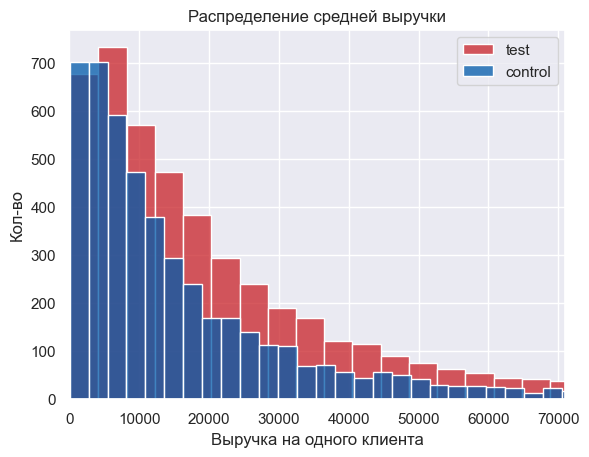

In [185]:
fig,ax = plt.subplots()
ax.set_xlim(0,70993.0)
sns.histplot(x=positive_arpu['cost'], bins=300, color='#C92228')
sns.histplot(x=negative_arpu['cost'], bins=300, color="#005AAB")
ax.set_title('Распределение средней выручки')
ax.set(xlabel='Выручка на одного клиента', ylabel='Кол-во')
ax.legend(['test','control'])

[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Выручка')]

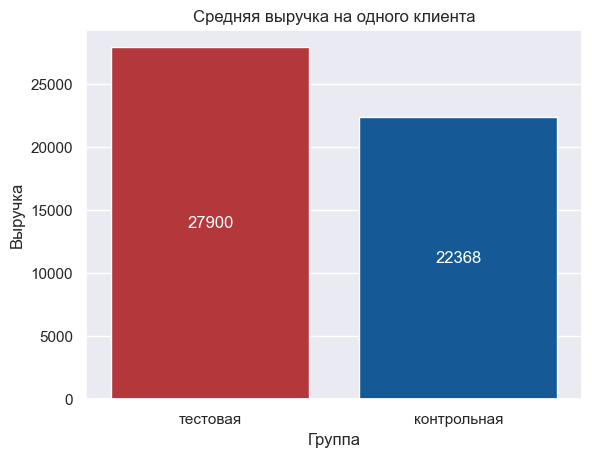

In [186]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(), 
                                                  negative_arpu['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средняя выручка на одного клиента')
ax.set(xlabel='Группа', ylabel='Выручка')

In [187]:
# Группируем покупки по дате и id, чтобы получить условный средний чек. 

bill_group = df_test.groupby(['dt','id'], as_index=False).agg({'cost':'sum'})

In [188]:
positive_bill = bill_group.loc[bill_group['id'].isin(positive_id), :]
len(positive_bill)

12517

In [189]:
negative_bill = bill_group.loc[bill_group['id'].isin(negative_id), :]
len(negative_bill)

11051

**Основная гипотеза**: нет статистически значимой разницы между средним чеком в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средним чеком в тестовой и контрольной группах.

In [190]:
# Проверка нормальности распределения 

print(stats.kstest(positive_bill['cost'], "norm"))
print(stats.kstest(negative_bill['cost'], "norm"))

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12, statistic_sign=-1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=39, statistic_sign=-1)


In [191]:
# В этом случае также используем критерий Манна-Уитни для проверки гипотезы о среднем чеке

mann = stats.mannwhitneyu(positive_bill['cost'], negative_bill['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=72554564.5, pvalue=7.639013623733095e-11)
Есть статистически значимая разница


In [192]:
print(get_outliers(positive_bill['cost']))
print(get_outliers(negative_bill['cost']))

(-10974.5, 26021.5)
(-10501.0, 24219.0)


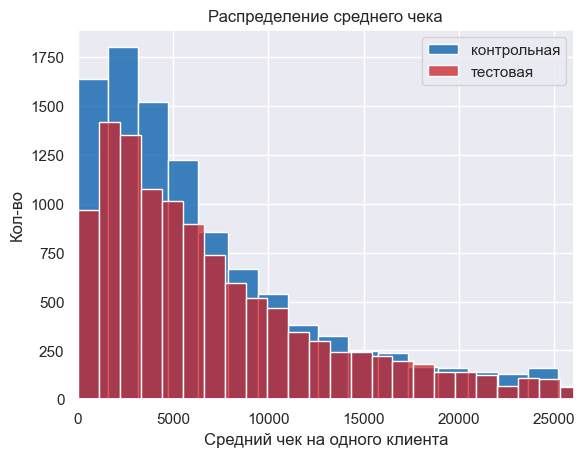

In [193]:
fig,ax = plt.subplots()
ax.set_xlim(0, 26021.5)
sns.histplot(x=negative_bill['cost'], bins=300, color="#005AAB")
sns.histplot(x=positive_bill['cost'], bins=300, color='#C92228')
ax.set_title('Распределение среднего чека')
ax.set(xlabel='Средний чек на одного клиента', ylabel='Кол-во')
ax.legend(['контрольная', 'тестовая'])

[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Средний чек')]

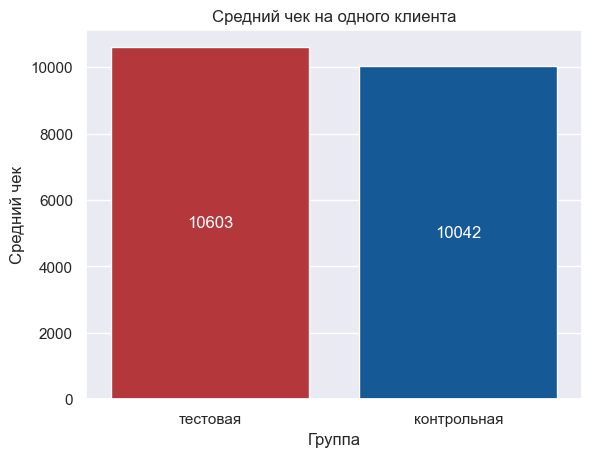

In [194]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(), 
                                                  negative_bill['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средний чек на одного клиента')
ax.set(xlabel='Группа', ylabel='Средний чек')

In [195]:
# Сгруппируем данные, чтобы получить количество покупок на одного клиента за время маркетинговой компании

count_group = df_test.groupby(['id'], as_index=False).agg({'cost':'count'})

In [196]:
positive_сount = count_group.loc[count_group['id'].isin(positive_id), :]
negative_сount = count_group.loc[count_group['id'].isin(negative_id), :]

**Основная гипотеза**: нет статистически значимой разницы между средним количеством купленных товаров  в тестовой и контрольной группах. 

**Альтернативная гипотеза**: есть статистически значимая разница между средним количеством купленных товаров в тестовой и контрольной группах.

In [197]:
# Проверка нормальности распределения 

print(stats.kstest(positive_сount['cost'], "norm"))
print(stats.kstest(negative_сount['cost'], "norm"))

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)
KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


In [198]:
# Используем критерий Манна-Уитни

mann = stats.mannwhitneyu(positive_сount['cost'], negative_сount['cost'])
print(mann)

if mann[1] < 0.05:
    print('Есть статистически значимая разница')
else:
    print('Статистически значимой разницы нет')

MannwhitneyuResult(statistic=14503562.5, pvalue=4.042645528365477e-87)
Есть статистически значимая разница


In [199]:
print(get_outliers(positive_сount['cost']))
print(get_outliers(negative_сount['cost']))

(-4.0, 12.0)
(-5.0, 11.0)


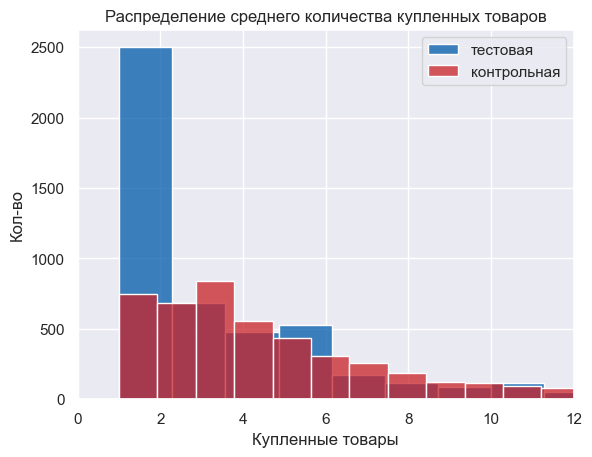

In [200]:
fig,ax = plt.subplots()
ax.set_xlim(0, 12)
sns.histplot(x=negative_сount['cost'], bins=70, color="#005AAB")
sns.histplot(x=positive_сount['cost'], bins=70, color='#C92228')
ax.set_title('Распределение среднего количества купленных товаров')
ax.set(xlabel='Купленные товары', ylabel='Кол-во')
ax.legend(['тестовая', 'контрольная'])

[Text(0.5, 0, 'Группа'), Text(0, 0.5, 'Кол-во')]

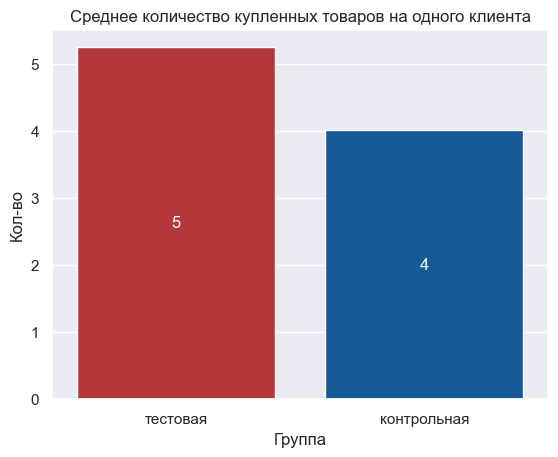

In [201]:
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(), 
                                                  negative_сount['cost'].mean()], 
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Среднее количество купленных товаров на одного клиента')
ax.set(xlabel='Группа', ylabel='Кол-во')

**Вывод**: по итогу проведенной первой маркетинговой компании средняя выручка на одного пользователя в тестовой группе выше на 25% чем в контрольной, средний чек выше на 6% и среднее количество купленных товаров одним клиентом выше на 31%. Из этих результатов можно сделать вывод, что маркетинговая компания была эффективна. 

## Clustering

In [202]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,2.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,2.0,0,27


In [203]:
df_g = df_purch.groupby('id', as_index=False).agg({'cost':'sum',
                                                   'product': pd.Series.mode,
                                                   'colour': pd.Series.mode,
                                                   'product_sex': pd.Series.mode,
                                                   'base_sale':'mean',
                                                   'dt':'max'
                                                   })

In [204]:
dict = {'cost': 'cost_sum',
        'product': 'product_mode',
        'colour': 'color_mode',
        'product_sex': 'product_sex_mode',
        'base_sale': 'best_sale_mean',
        'dt': 'dt_max'}

df_g = df_g.rename(columns=dict)

In [205]:
df_g

,id,cost_sum,product_mode,color_mode,product_sex_mode,best_sale_mean,dt_max
0,0,19897,"[Велосипед горный женский Stern Mira 2.0 26"", ...","[бежевый, белый/синий, зелёный]",2.0,0.333333,37
1,3,14596,"[Бутсы мужские GSD Astro, Кеды мужские FILA A-...",белый,1.0,0.250000,34
2,4,31093,"[Куртка утепленная для девочек Outventure, Наб...","[белый, белый/серый, другой, мультицвет, розов...",2.0,0.000000,32
3,6,84085,[Ботинки утепленные для мальчиков Reima Uskall...,черный,1.0,0.400000,30
4,7,58827,Бутсы для мальчиков Nike Jr. Tiempo Legend 9 A...,черный,2.0,0.384615,49
...,...,...,...,...,...,...,...
104984,177998,20732,Юбка-шорты женская FILA,белый,0.0,0.750000,30
104985,177999,148289,"[Велосипед городской Stern Urban 28"", 2022, Па...",черный,2.0,0.181818,49
104986,178001,48289,"[Кроссовки мужские FILA Base, Полуботинки мужс...","[другой, темно-синий]",1.0,0.090909,46
104987,178002,11397,[Бейсболка New Era 9Forty MLB New York Yankees...,другой,1.0,0.000000,57


In [206]:
mode_columns = ['product_mode', 'color_mode', 'product_sex_mode']

for column in mode_columns:
    df_g[column] = df_g[column].apply(lambda x: x[0] if type(x) == np.ndarray else x)

In [207]:
df = pd.merge(left=df_clients, right=df_g, on='id', how='inner')

In [208]:
df.head()

,id,gender,age,education,city,country,personal_coef,cost_sum,product_mode,color_mode,product_sex_mode,best_sale_mean,dt_max
0,0,0.0,36,1,1201,32,0.5072,19897,"Велосипед горный женский Stern Mira 2.0 26""",бежевый,2.0,0.333333,37
1,4,0.0,35,1,1134,32,0.5072,31093,Куртка утепленная для девочек Outventure,белый,2.0,0.000000,32
2,6,1.0,52,1,1188,32,0.4304,84085,Ботинки утепленные для мальчиков Reima Uskallus,черный,1.0,0.400000,30
3,7,0.0,37,1,1198,32,0.5072,58827,Бутсы для мальчиков Nike Jr. Tiempo Legend 9 A...,черный,2.0,0.384615,49
4,9,0.0,48,1,1134,32,0.5072,63290,Куртка мембранная женская Outventure,милитари,0.0,0.900000,56


In [209]:
df = df.drop(columns=['id'])

In [210]:
num_columns = ['age', 'personal_coef','cost_sum', 'best_sale_mean','dt_max']

In [211]:
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

In [212]:
n_clusters = list(range(2,8))
cost = []

for n in n_clusters:
    kproto = KPrototypes(n_clusters=n, init='Cao', n_jobs=-1)
    kproto.fit_predict(df, categorical=[0,2,3,4,7,8,9])
    cost.append(kproto.cost_)

<Axes: >

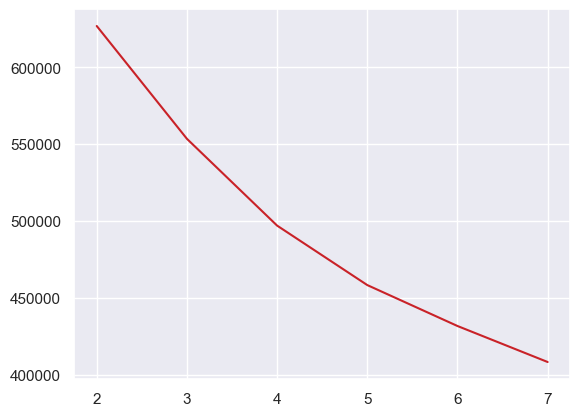

In [213]:
sns.lineplot(x=n_clusters, y=cost, color='#C92228')

In [ ]:
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df, categorical=[0,2,3,4,7,8,9])

array([1, 0, 2, ..., 1, 0, 2], dtype=uint16)

In [ ]:
tsne = TSNE(n_components=2, perplexity=40)
df_emb = tsne.fit_transform(df[num_columns])
data = pd.DataFrame(df_emb)

<Axes: xlabel='0', ylabel='1'>

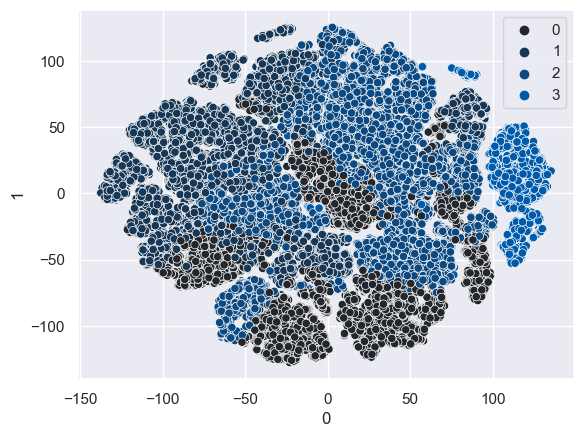

In [140]:
pallete = sns.color_palette("dark:#005AAB", as_cmap=True)

sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete)

In [141]:
df[num_columns] = scaler.inverse_transform(df[num_columns])

num_columns.extend(['education','gender'])
mode_cols = set(df.columns) - set(num_columns)

d1 = dict.fromkeys(num_columns, 'mean')
d2 = dict.fromkeys(mode_cols, pd.Series.mode)

In [164]:
d = {**d1, **d2}
df_g = df.groupby(kproto.labels_, as_index=False).agg(d)
df_g = df_g.round(2).T
df_g.rename(columns={0:'cluster 1', 1:'cluster 2', 2:'cluster 3', 3:'cluster 4'})

,cluster 1,cluster 2,cluster 3,cluster 4
age,38.42,38.74,40.87,15.83
personal_coef,0.47,0.49,0.45,0.27
cost_sum,26263.83,28075.5,60293.01,38004.59
best_sale_mean,0.16,0.62,0.22,0.33
dt_max,23.48,43.83,50.33,39.46
education,0.8,0.8,0.86,0.2
gender,0.62,0.28,0.75,0.68
color_mode,другой,черный,другой,черный
country,32,32,32,32
product_sex_mode,2.0,0.0,1.0,1.0
